# Cheminformatics in Python: Predicting Solubility of Molecules

In this notebook, we dive into the world of Cheminformatics which lies at the interface of Informatics and Chemistry. We will be reproducing a research article (by John S. Delaney) by applying Linear Regression to predict the solubility of molecules (i.e. solubility of drugs is an important physicochemical property in Drug discovery, design and development).

This idea for this notebook was inspired by the excellent blog post by Pat Walters where he reproduced the linear regression model with similar degree of performance as that of Delaney. This example is also briefly described in the book <u>Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More</u>.

## 1. Install RDKit

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
!conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## 2. Delaney's solubility dataset

The original [Delaney's dataset](https://pubs.acs.org/doi/10.1021/ci034243x) available as a [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x). The full paper is entitled [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).

### 2.1. Download the dataset

In [2]:
!wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

--2021-06-08 23:36:05--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Resolving pubs.acs.org (pubs.acs.org)... 104.18.1.20, 104.18.0.20
Connecting to pubs.acs.org (pubs.acs.org)|104.18.1.20|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt?cookieSet=1 [following]
--2021-06-08 23:36:05--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt?cookieSet=1
Reusing existing connection to pubs.acs.org:443.
HTTP request sent, awaiting response... 302 Found
Location: https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt [following]
--2021-06-08 23:36:05--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Reusing existing connection to pubs.acs.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 60034 (59K

In [3]:
!wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2021-06-08 23:36:09--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.01s   

2021-06-08 23:36:09 (5.42 MB/s) - ‘delaney.csv’ saved [58889/58889]



### 2.2. Read in the dataset

In [4]:
import pandas as pd

In [5]:
sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


### 2.3. Examining the SMILES data

Chemical structures are encoded by <b>SMILES</b> which is an acronym for <b>Simplified Molecular-Input Line-Entry System</b>.

In [6]:
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

In [7]:
sol.SMILES[0]

'ClCC(Cl)(Cl)Cl'

### 2.4. Convert a molecule from the SMILES string to an rdkit object

In [8]:
from rdkit import Chem

In [9]:
Chem.MolFromSmiles(sol.SMILES[0])

In [10]:
Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

### 2.5. Working with rdkit object

In [11]:
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [12]:
m.GetNumAtoms()

6

## 3. Calculate molecular descriptors in rdkit

### 3.1. Convert list of molecules to rdkit object

In [14]:
from rdkit import Chem

#### 3.1.1. Method 1

In [15]:
mol_list= []

for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [16]:
len(mol_list)

1144

In [17]:
mol_list[:5]

#### 3.1.2. Method 2

In [18]:
mol_list2 = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [19]:
len(mol_list2)

1144

In [20]:
mol_list2[:5]

### 3.2. Calculate molecular descriptors
To predict <b>LogS</b> (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:

1. <b>cLogP</b> (<i>Octanol-water partition coefficient</i>)
2. <b>MW</b> (<i>Molecular weight</i>)
3. <b>RB</b> (<i>Number of rotatable bonds</i>)
4. <b>AP</b> (<i>Aromatic proportion = number of aromatic atoms / total number of heavy atoms</i>)

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the <i>number of aromatic atoms</i> to the total <i>number of heavy atoms</i> which rdkit can compute.

#### 3.2.1. LogP, MW and RB

In [21]:
import numpy as np
from rdkit.Chem import Descriptors

In [22]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [23]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#### 3.2.2. Aromatic proportion

##### <i>3.2.1.1. Number of aromatic atoms</i>

Here, we will create a custom function to calculate the <b>Number of aromatic atoms</b>. With this descriptor we can use it to subsequently calculate the AP descriptor.

Computing for a single molecule.

In [24]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [25]:
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [26]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [27]:
AromaticAtoms(m)

19

Computing for molecules in the entire dataset.

In [28]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

##### <i>3.2.1.2. Number of heavy atoms</i>

Here, we will use an existing function for calculating the Number of heavy atoms.

Computing for a single molecule.

In [29]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
Descriptors.HeavyAtomCount(m)

34

Computing for molecules in the entire dataset.

In [30]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

##### <i>3.2.1.3. Computing the Aromatic Proportion (AP) descriptor</i>

Computing for a single molecule.

In [31]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

Computing for molecules in the entire dataset.

In [32]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [33]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


### 3.3. X matrix (Combining all computed descriptors into 1 dataframe)

In [34]:
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [35]:
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


Let's combine the 2 dataframes to produce the <b>X</b> matrix

In [36]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


### 3.4. Y matrix

In [37]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Assigning the second column (index 1) to the Y matrix

In [38]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

### Data split

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Linear Regression Model

In [41]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Predicts the X_train

In [43]:
Y_pred_train = model.predict(X_train)

In [44]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.72830809 -0.00689728  0.01547348 -0.35536595]
Intercept: 0.2280215390713929
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


#### Predicts the X_test

In [45]:
Y_pred_test = model.predict(X_test)

In [46]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.72830809 -0.00689728  0.01547348 -0.35536595]
Intercept: 0.2280215390713929
Mean squared error (MSE): 1.00
Coefficient of determination (R^2): 0.75


#### Linear Regression Equation

The work of Delaney provided the following linear regression equation:

    LogS = 0.16 - 0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP

The reproduction by Pat Walters provided the following:

    LogS = 0.26 - 0.74 LogP - 0.0066 MW + 0.0034 RB - 0.42 AP

This notebook's reproduction gave the following equation:

* Based on the Train set

        LogS = 0.30 -0.75 LogP - .0066 MW -0.0041 RB - 0.36 AP

* Based on the Full dataset

        LogS = 0.26 -0.74 LogP - 0.0066 + MW 0.0032 RB - 0.42 AP

##### Our linear regression equation

In [47]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3] ) )

LogS = 0.23 -0.73 LogP -0.0069 MW 0.0155 RB -0.36 AP


The same equation can also be produced with the following code (which breaks up the previous one-line code into several comprehensible lines).

In [48]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]

In [49]:
print('LogS = ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS =  0.23 -0.73 LogP -0.0069 MW 0.0155 RB -0.36 AP


##### Use entire dataset for model training (For Comparison)

In [50]:
full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
full_pred = model.predict(X)

In [52]:
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [53]:
full_yintercept = '%.2f' % full.intercept_
full_LogP = '%.2f LogP' % full.coef_[0]
full_MW = '%.4f MW' % full.coef_[1]
full_RB = '+ %.4f RB' % full.coef_[2]
full_AP = '%.2f AP' % full.coef_[3]

In [54]:
print('LogS = ' + 
      ' ' + 
      full_yintercept + 
      ' ' + 
      full_LogP + 
      ' ' + 
      full_MW + 
      ' ' + 
      full_RB + 
      ' ' + 
      full_AP)

LogS =  0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


### Scatter plot of experimental vs. predicted LogS

In [55]:
import matplotlib.pyplot as plt

#### Quick check of the variable dimensions of Train and Test sets

In [56]:
Y_train.shape, Y_pred_train.shape

((915,), (915,))

In [57]:
Y_test.shape, Y_pred_test.shape

((229,), (229,))

#### Vertical plot

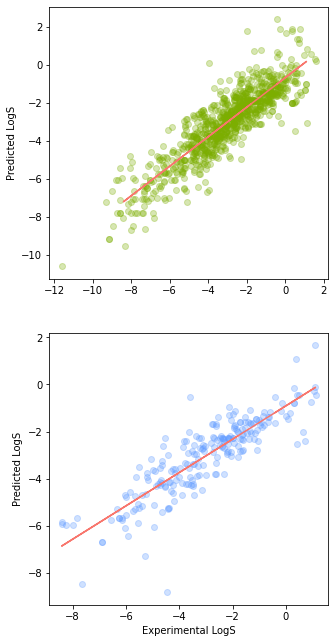

In [58]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

#### Horizontal plot

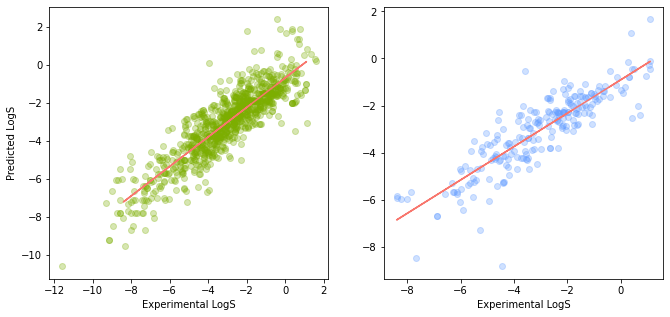

In [59]:
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

In [60]:
!ls -l

total 83356
-rw-r--r-- 1 root root    60034 Apr 22  2008 ci034243xsi20040112_053635.txt
-rw-r--r-- 1 root root    58889 Jun  8 23:36 delaney.csv
-rwxr-xr-x 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh
-rw-r--r-- 1 root root    30119 Jun  9 00:03 plot_horizontal_logS.pdf
-rw-r--r-- 1 root root    49981 Jun  9 00:03 plot_horizontal_logS.png
-rw-r--r-- 1 root root    30112 Jun  9 00:02 plot_vertical_logS.pdf
-rw-r--r-- 1 root root    51283 Jun  9 00:02 plot_vertical_logS.png
drwxr-xr-x 1 root root     4096 Jun  1 13:40 sample_data


## Predicting Solubility of Molecules using <i>PyCaret</i> 

### 1. Install PyCaret

In [ ]:
!pip install pycaret==1.0.0

### 2. Read in dataset

In [2]:
import pandas as pd

In [3]:
delaney_with_descriptors_url = 'https://raw.githubusercontent.com/dataprofessor/data/master/delaney_solubility_with_descriptors.csv'
dataset = pd.read_csv(delaney_with_descriptors_url)

In [4]:
dataset

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


### 3. Model Building

#### 3.1. Model Setup

In [5]:
from pycaret.regression import *

In [6]:
model = setup(data = dataset, target = 'logS', train_size=0.8, silent=True)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2824
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(1144, 5)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### 3.2. Model comparison

Subsequent blocks of codes here will be using the training set (the 80% subset) for model building.

In [7]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.513100,0.520000,0.717700,0.873900,0.203000,-0.017300
1,CatBoost Regressor,0.539500,0.532800,0.727900,0.870000,0.207700,-0.028000
2,Random Forest,0.541700,0.570300,0.751900,0.861500,0.212900,-0.037200
3,Light Gradient Boosting Machine,0.554100,0.590000,0.764800,0.856300,0.217400,-0.032300
4,Extreme Gradient Boosting,0.591900,0.609800,0.778400,0.851500,0.230000,-0.039000
5,Gradient Boosting Regressor,0.589000,0.611400,0.779700,0.851400,0.229200,-0.046800
6,AdaBoost Regressor,0.706700,0.791100,0.888000,0.806700,0.245200,-0.117300
7,Decision Tree,0.688700,0.983300,0.988800,0.755100,0.264000,-0.084600
8,Linear Regression,0.770100,1.014000,1.001400,0.752300,0.288200,-0.285000
9,Ridge Regression,0.770200,1.014000,1.001400,0.752300,0.288100,-0.285600


#### 3.3. Model Creation

In [8]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4305,0.4107,0.6409,0.9052,0.2088,-0.2935
1,0.4814,0.4454,0.6674,0.8817,0.2252,-0.3270
2,0.4684,0.4188,0.6471,0.8670,0.1990,-0.1527
3,0.5324,0.5604,0.7486,0.8739,0.2089,0.0167
4,0.5891,0.7147,0.8454,0.8804,0.2195,0.0550
5,0.5221,0.4929,0.7021,0.8872,0.1992,1.5356
6,0.5953,0.6984,0.8357,0.8405,0.2146,-0.5274
7,0.5227,0.5183,0.7199,0.8522,0.1886,-0.2102
8,0.4954,0.5199,0.7211,0.8559,0.1908,0.0196
9,0.4940,0.4208,0.6487,0.8956,0.1752,-0.2893


#### 3.4. Model Tuning

The learning parameters are subjected to optimization at this phase. Here, 50 iterations is used for the optimization process and the fitness function is the Mean Absolute Error (MAE) which is the performance metric used to judge at which learning parameter settings are optimal.

In [9]:
tuned_et = tune_model('et', n_iter = 50, optimize = 'mae')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4724,0.4626,0.6802,0.8932,0.2125,-0.2941
1,0.4986,0.4459,0.6678,0.8815,0.2181,-0.4170
2,0.5026,0.4487,0.6699,0.8575,0.1999,-0.1306
3,0.5076,0.4809,0.6934,0.8918,0.2029,0.0485
4,0.6168,0.7033,0.8386,0.8823,0.2278,0.1157
5,0.5420,0.5100,0.7141,0.8833,0.2074,1.5717
6,0.5939,0.7019,0.8378,0.8397,0.2153,-0.5764
7,0.4910,0.4841,0.6958,0.8619,0.1845,-0.2043
8,0.5098,0.4839,0.6956,0.8659,0.1947,0.0260
9,0.5133,0.4450,0.6671,0.8896,0.1816,-0.2861


In [10]:
print(tuned_et)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=30, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=7, min_weight_fraction_leaf=0.0,
                    n_estimators=210, n_jobs=None, oob_score=False,
                    random_state=2824, verbose=0, warm_start=False)


### 4. Model Analysis

#### 4.1. Plot Models

In this tutorial, we are performing regression and so further details of the regression plots are available at https://pycaret.org/plot-model/.

##### Residuals Plot

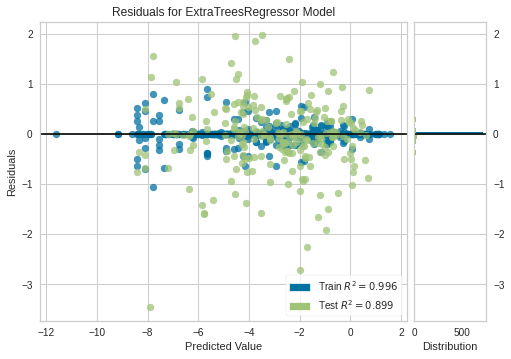

In [11]:
plot_model(et, 'residuals')

##### Prediction Error Plot

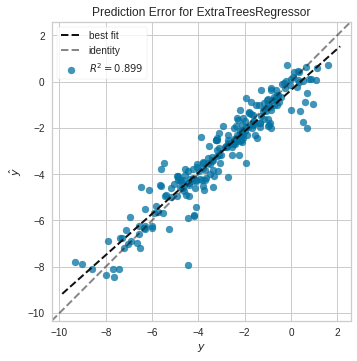

In [12]:
plot_model(et, 'error')

##### Cooks Distance Plot

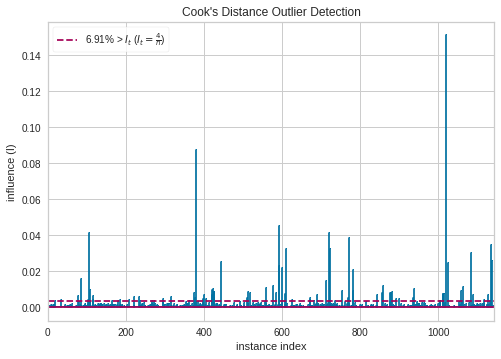

In [13]:
plot_model(et, 'cooks')

##### Recursive Feature Selection

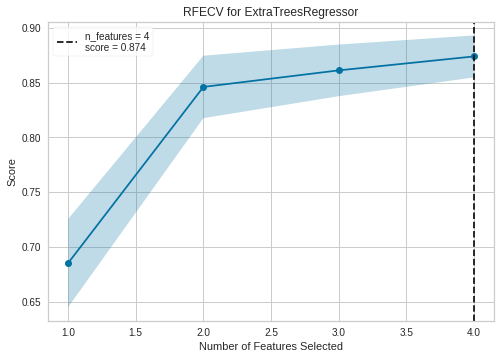

In [14]:
plot_model(et, 'rfe')

##### Learning Curve

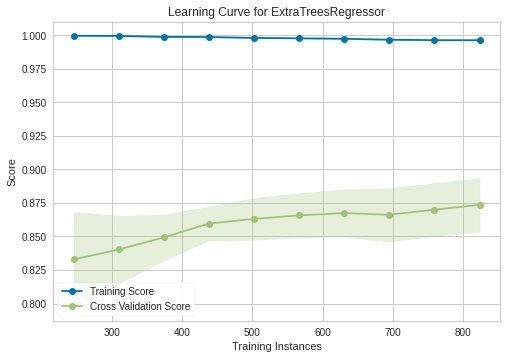

In [15]:
plot_model(et, 'learning')

##### Validation Curve

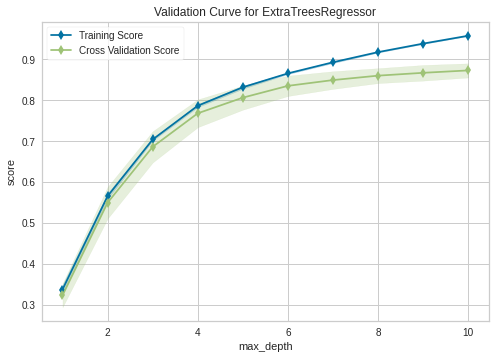

In [16]:
plot_model(et, 'vc')

##### Manifold Learning

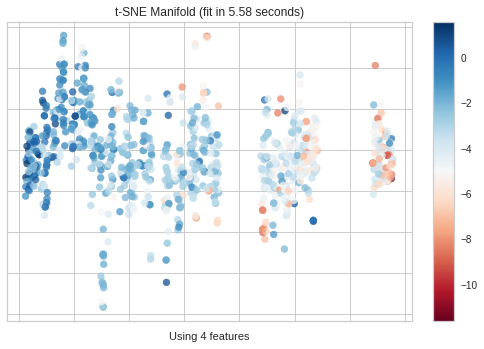

In [17]:
plot_model(et, 'manifold')

##### Feature Importance

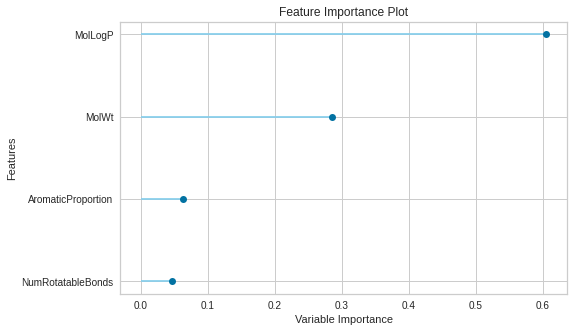

In [18]:
plot_model(et, 'feature')

##### Model Hyperparameter

The hyperparameter of the learning model is displayed using the parameter argument in inside the `plot_model()` function.

In [19]:
plot_model(et, 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None
min_samples_leaf,1


Here, the hyperparameter of the tuned model is displayed below.

In [20]:
plot_model(tuned_et, 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0
criterion,mse
max_depth,30
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None
min_samples_leaf,1


##### Show all plots

The `evaluate_model()` displays all available plots here.

In [21]:
evaluate_model(tuned_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### 4.2. Model Interpretation

The `interpret_model()` function of PyCaret leverages the use of the SHAP library to produce stunning plots for depicting the <b>SHAP (SHapley Additive exPlanations)</b> values originally proposed by Lundberg and Lee in 2016. SHAP plots adds interpretability to constructed models so that the contribution of each features to the prediction can be elucidated.

##### Summary Plot

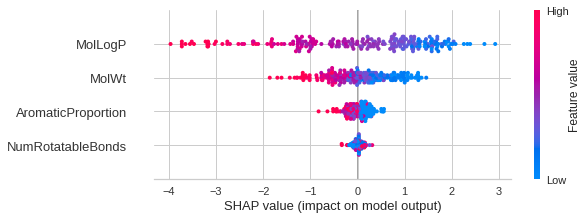

In [22]:
interpret_model(et)

##### Correlation Plot

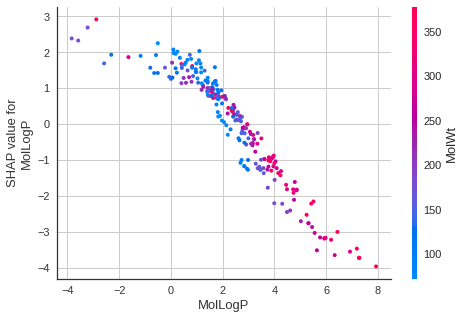

In [23]:
interpret_model(et, plot = 'correlation')

##### Reason Plot at Observation Level

The <i>Reason Plot at Observation Level</i> as called by PyCaret is better known as the <b>force plot</b> and describes the <b><i>push and pull effect</b></i> that each individual features has on the <b>base value</b> that eventually leads to the predicted <b>output value</b>.

In [24]:
interpret_model(et, plot = 'reason', observation = 10)

#### External Testing

We will now apply the trained model (built with 80% subset) to evaluate on the so-called <b>"hold-out"</b> testing set (the 20% subset) that serves as the unseen data.

In [25]:
prediction_holdout = predict_model(et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.506,0.5196,0.7208,0.8987,0.1957,0.1921


In [26]:
prediction_holdout.head()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS,Label
0,-0.50840,59.068,0.0,0.000000,1.58,0.7047
1,0.52988,41.053,0.0,0.000000,0.26,-0.2459
2,2.13860,82.146,1.0,0.000000,-2.40,-2.6973
3,4.00700,188.657,1.0,0.923077,-4.54,-4.8800
4,3.45664,156.228,0.0,0.833333,-4.14,-4.5900
